<h1>Data Processing</h1>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-07-10 11:34:03.623362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752122043.715916   19640 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752122043.742376   19640 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752122043.933217   19640 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752122043.933233   19640 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752122043.933235   19640 computation_placer.cc:177] computation placer alr

In [2]:
base_path = Path('data/images/')

In [3]:
image_count = len(list(base_path.rglob('*/*.jpg')))
print(image_count)

35887


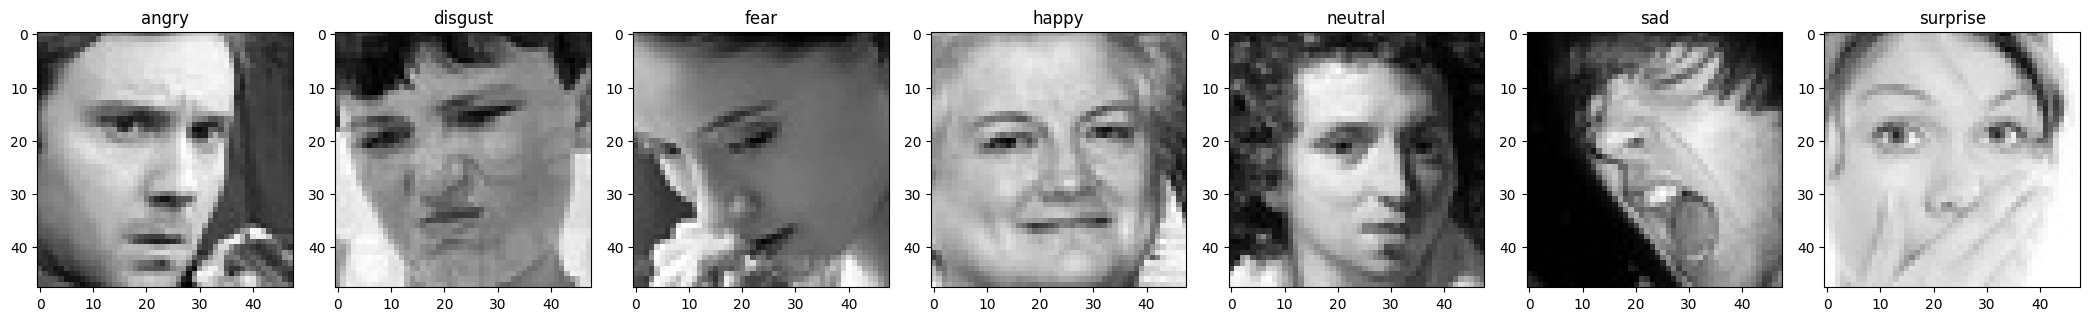

In [4]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

fig, axes = plt.subplots(1, len(labels), figsize=(3 * len(labels), 4))

for i, label in enumerate(labels):
    folder_path = os.path.join(base_path, label)
    image_files = sorted(os.listdir(folder_path))
    if not image_files:
        continue
    first_image = os.path.join(folder_path, image_files[0])
    img = Image.open(first_image)
    
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(label)
plt.tight_layout()    
plt.show()

In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode='rgb'

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 35887 files belonging to 7 classes.
Using 28710 files for training.


I0000 00:00:1752122050.087953   19640 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5565 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:08:00.0, compute capability: 8.6


Found 35887 files belonging to 7 classes.
Using 7177 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(200).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

<h1>Model</h1>

In [10]:
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    include_preprocessing=True
)

In [11]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

<h1>Training</h1>

In [13]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1752122077.955960   19763 service.cc:152] XLA service 0x7e23dc0031c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752122077.955980   19763 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-07-10 11:34:38.612342: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752122082.091556   19763 cuda_dnn.cc:529] Loaded cuDNN version 91001
2025-07-10 11:34:49.105255: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 11:34:49.216263: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, p

801/898 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.3954 - loss: 1.5527

2025-07-10 11:35:59.941580: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 11:36:00.050888: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 11:36:01.122553: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 11:36:01.235490: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 11:36:01.348330: E external/local_xla/xla/stream_

898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4067 - loss: 1.5270

2025-07-10 11:36:28.278843: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2298', 84 bytes spill stores, 84 bytes spill loads

2025-07-10 11:36:28.329787: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2298', 212 bytes spill stores, 212 bytes spill loads

2025-07-10 11:36:28.630618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2298', 1604 bytes spill stores, 1604 bytes spill loads

2025-07-10 11:36:28.815804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2298', 5984 bytes spill stores, 5984 bytes spill loads

2025-07-10 11:36:36.034836: I 

898/898 ━━━━━━━━━━━━━━━━━━━━ 152s 104ms/step - accuracy: 0.4068 - loss: 1.5267 - val_accuracy: 0.6076 - val_loss: 1.0341
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6330 - loss: 0.9906

898/898 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.6330 - loss: 0.9906 - val_accuracy: 0.6457 - val_loss: 0.9632
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6994 - loss: 0.8145

898/898 ━━━━━━━━━━━━━━━━━━━━ 50s 55ms/step - accuracy: 0.6995 - loss: 0.8145 - val_accuracy: 0.6642 - val_loss: 0.9547
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.7652 - loss: 0.6607 - val_accuracy: 0.6713 - val_loss: 0.9903
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.8101 - loss: 0.5234 - val_accuracy: 0.6646 - val_loss: 1.0565
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.8622 - loss: 0.3914 - val_accuracy: 0.6733 - val_loss: 1.1675
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.8932 - loss: 0.3039 - val_accuracy: 0.6734 - val_loss: 1.2069
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 49s 54ms/step - accuracy: 0.9146 - loss: 0.2427 - val_accuracy: 0.6687 - val_loss: 1.3750
